## Add Library

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, Adadelta

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import cv2
import pickle
import random 
import time
import zipfile
from shutil import copyfile
from sklearn.model_selection import train_test_split

## Add dataset

### Read HODA Dataset

In [2]:
# Hoda Dataset Reader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [3]:
dataset_path = "D:\\learning\\EE Courses\\Neural Network (D. Kalhor)\\HW\\HW Extra\\handwritten-Persian-numbers-recognition\\Data\\Hoda Dataset\\"
# size of images
image_size = 40

### Load trainand test dataset

In [4]:
# load train images
train_images, train_labels = read_hoda_dataset(dataset_path=dataset_path+"Train 60000.cdb",
                                images_height=image_size,
                                images_width=image_size,
                                one_hot=False,
                                reshape=True)

In [5]:
# load test images
X_test, y_test = read_hoda_dataset(dataset_path=dataset_path+"Test 20000.cdb",
                                images_height=image_size,
                                images_width=image_size,
                                one_hot=False,
                                reshape=True)

In [6]:
# make val dataset
test_images, val_images, test_labels, val_labels = train_test_split(
    X_test.astype(np.float32), y_test, test_size=0.5, random_state=1234)

In [7]:
# shape of train, test and validation dataset respectively
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(60000, 1600)
(10000, 1600)
(10000, 1600)


In [8]:
# reshape images to the required size 
train_images = train_images.reshape(train_images.shape[0], image_size, image_size)
val_images = val_images.reshape(val_images.shape[0], image_size, image_size)
test_images = test_images.reshape(test_images.shape[0], image_size, image_size)

In [9]:
# shape of sample respectively
print(train_images.shape)

(60000, 40, 40)


### Show dataset sample

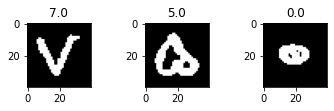

In [10]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

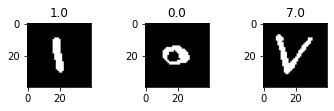

In [11]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(test_labels[i])

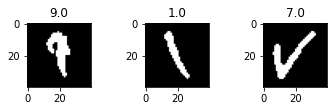

In [12]:
#val samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(val_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(val_labels[i])

## Preprocessing data

In [13]:
def preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val):
    
    # reshape images to the required size 
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)

    
    
    # convert image values from integers to floats
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')



    # normalization 
#     X_train = X_train/255.0
#     X_test = X_test/255.0
#     X_test = X_val/255.0
    
    
    # One-hot encoding label 
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_val = to_categorical(y_val)


    return X_train, y_train, X_test, y_test, X_val, y_val

## Define Model

In [14]:
def DCNN():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(image_size, image_size,1)))
    
    # Convolutional Block 1
    model.add(Conv2D(64, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.1))

    # Convolutional Block 2
    model.add(Conv2D(128, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.2))
    
    # Convolutional Block 3
    model.add(Conv2D(256, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.3))
    
    # Convolutional Block 4
    model.add(Conv2D(512, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3,3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(Dropout(0.4))

    # Classification Block 
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))  
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # The output layer
    model.add(Dense(10, activation='softmax'))  
    
    
    # Optimizer
    
    opt = SGD(momentum=0.9) # Momentum optimizer
#     opt = Adam() # Adam optimizer
#     opt = Adadelta() # Adadelta optimizer


    model.compile(loss = 'categorical_crossentropy', 
                    optimizer = opt, 
                    metrics = ['accuracy']) 
    return model

optimization = 'Adam'

In [15]:
DCNN_model = DCNN()
DCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 19, 19, 128)       0

## Training model

In [16]:
def train_model(model, X_train, y_train, X_test, y_test, X_val, y_val, epochs = 50, batch_size = 64):
    
    # Preprocess all training and testing data
    X_train, y_train, X_test, y_test, X_val, y_val= preprocess_data(X_train, y_train,
                                                                  X_test, y_test, 
                                                                  X_val, y_val)

    # Callbacks
    tensorboard_callback = TensorBoard(log_dir=f"./logs_{optimization}")
    model_checkpoint_callback = ModelCheckpoint(filepath=f"./checkpoint_{optimization}",
                                                verbose=1, 
                                                save_best_only=True,
#                                                 save_weights_only=True, 
                                                monitor='val_accuracy', 
                                                mode='max'
                                               )
    earlyStopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max',)
    
    # Fitting the model on the training set
    history = model.fit(X_train, y_train, 
                        epochs = epochs, 
                        batch_size = batch_size, 
                        steps_per_epoch = X_train.shape[0]//batch_size,
                        validation_data = (X_val,y_val), 
                        callbacks = [tensorboard_callback, model_checkpoint_callback, earlyStopping_callback]
                       )
    
    
    # evaluating the model
    print("\n\nmodel evaluation :")
    _, acc = model.evaluate(X_val, y_val, verbose = 1)
    print('validation accuracy : %.3f' % (acc * 100.0))
    
    return history

In [17]:
history = train_model(DCNN_model, train_images, train_labels, test_images, test_labels, val_images, val_labels)

Epoch 1/50
937/937 [==============================] - 33s 32ms/step - loss: 0.1406 - accuracy: 0.9586 - val_loss: 0.0593 - val_accuracy: 0.9831

Epoch 00001: val_accuracy improved from -inf to 0.98310, saving model to .\checkpoint_Adam
INFO:tensorflow:Assets written to: .\checkpoint_Adam\assets
Epoch 2/50
937/937 [==============================] - 30s 31ms/step - loss: 0.0356 - accuracy: 0.9898 - val_loss: 0.0381 - val_accuracy: 0.9887

Epoch 00002: val_accuracy improved from 0.98310 to 0.98870, saving model to .\checkpoint_Adam
INFO:tensorflow:Assets written to: .\checkpoint_Adam\assets
Epoch 3/50
937/937 [==============================] - 29s 31ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0243 - val_accuracy: 0.9933

Epoch 00003: val_accuracy improved from 0.98870 to 0.99330, saving model to .\checkpoint_Adam
INFO:tensorflow:Assets written to: .\checkpoint_Adam\assets
Epoch 4/50
937/937 [==============================] - 29s 31ms/step - loss: 0.0191 - accuracy: 0.9940 - va

### Plot of accuracy

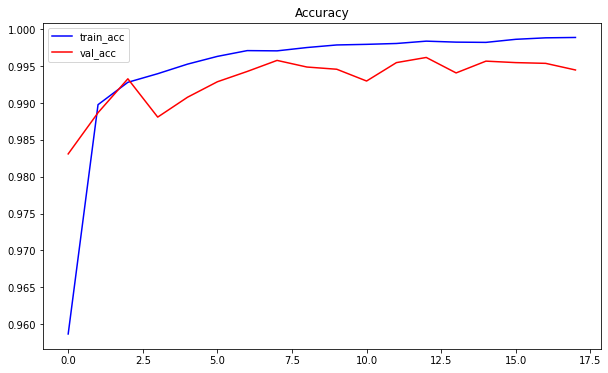

In [18]:
plt.figure(figsize = (10,6))
plt.plot(history.history['accuracy'], color = 'blue', label = 'train_acc')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

### Plot of loss

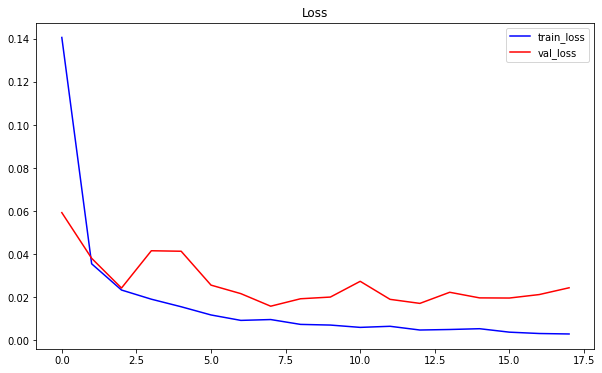

In [19]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], color = 'blue', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'val_loss')
plt.legend()
plt.title('Loss')
plt.show()

In [20]:
with open(f'./logs_{optimization}/{optimization}.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Test

In [21]:
DCNN_model = tf.keras.models.load_model(f"./checkpoint_{optimization}")

In [22]:
# load test images
X_test, y_test = read_hoda_dataset(dataset_path=dataset_path+"Test 20000.cdb",
                                images_height=image_size,
                                images_width=image_size,
                                one_hot=False,
                                reshape=True)

X_test = X_test.reshape(-1, image_size, image_size, 1)
print(X_test.shape)

(20000, 40, 40, 1)


In [23]:
y_pred = DCNN_model.predict(X_test, verbose=1)

625/625 [==============================] - 3s 5ms/step


In [24]:
y_pred = np.array([np.argmax(vector) for vector in (y_pred>=0.5)])

### Percision, Recall, F1 Score, Confusion matrix

In [25]:
print('Percision Score : {}\n'.format(precision_score(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')))
print('Recall Score : {}\n'.format(recall_score(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')))
print('F1 Score : {}\n'.format(f1_score(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')))
print('Confusion Matrix : \n\n{}'.format(confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])))

Percision Score : 0.99595

Recall Score : 0.99595

F1 Score : 0.99595

Confusion Matrix : 

[[1994    0    0    0    2    4    0    0    0    0]
 [   2 1994    2    0    0    0    0    0    0    2]
 [   0    1 1981   12    5    0    0    0    0    1]
 [   0    0    5 1988    7    0    0    0    0    0]
 [   0    0    2    3 1994    1    0    0    0    0]
 [   4    0    0    0    2 1994    0    0    0    0]
 [   0    2    1    0    1    4 1987    0    0    5]
 [   1    1    1    0    0    0    1 1996    0    0]
 [   0    1    0    0    0    0    0    0 1998    1]
 [   1    5    0    0    0    1    0    0    0 1993]]


### Comparison between algorithms

In [39]:
with open(f'./out 1/logs_SGD/SGD.pickle', 'rb') as handle:
    sgd_history = pickle.load(handle)

with open(f'./out 1/logs_Adam/Adam.pickle', 'rb') as handle:
    adam_history = pickle.load(handle)
    
with open(f'./out 1/logs_delta/delta.pickle', 'rb') as handle:
    adadelta_history = pickle.load(handle)

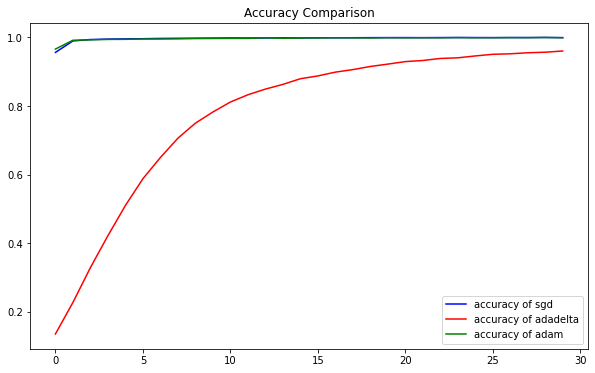

In [41]:
plt.figure(figsize = (10,6))
plt.plot(sgd_history['accuracy'], color = 'blue', label = 'accuracy of sgd')
plt.plot(adadelta_history['accuracy'], color = 'red', label = 'accuracy of adadelta')
plt.plot(adam_history['accuracy'], color = 'green', label = 'accuracy of adam')
plt.legend()
plt.title('Accuracy Comparison')
plt.show()